# Lab Assignment One: Lab Assignment Six: Convolutional Network Architectures

CS 5324

2021-05-02

Anthony Wang

## Preparation

[The image dataset](https://www.kaggle.com/crowww/a-large-scale-fish-dataset) is a collection of pictures taken of nine types of seafood in a Turkish supermarket. The seafood include gilt head bream, red sea bream, sea bass, red mullet, horse mackerel, black sea sprat, striped red mullet, trout, and shrimp. Classification accuracy will be used to evaluate the convolutional neural network trained on these images. Given the completely balanced data set, accuracy is sufficient to give a good sense of model performance. Because accuracy is equally valuable for each class, no detrimental effects should arise from taking their mean to use as a metric. Misclassification is not extremely costly in most applications, as simply results in a fish being placed in the wrong bin at a store.

In [1]:
import numpy as np
from PIL import Image

seafood_types = [
    "Black Sea Sprat",
    "Gilt-Head Bream",
    "Horse Mackerel",
    "Red Mullet",
    "Red Sea Bream",
    "Sea Bass",
    "Shrimp",
    "Striped Red Mullet",
    "Trout"
]

# Determine scaled image dimensions
dataset_root = "D:\\Fish_Dataset\\"
url = dataset_root + seafood_types[0] + "/" + str(1).zfill(5) + ".png"
image = Image.open(url)
width = image.size[0] // 5
size = image.size[1] // 5
crop_left = (width - size) // 2
crop_right = (width + size) // 2
channels = 3
labels = len(seafood_types)

X = np.empty((9000, size, size, channels))
y = np.empty((9000,), dtype='i1')

for i in range(labels):
    print("Loading", seafood_types[i], "images...")
    for j in range(1000):
        # Load image
        url = dataset_root + seafood_types[i] + "/" + str(j + 1).zfill(5) + ".png"
        image = Image.open(url)

        # Scale to 1/4 size and crop to square
        image = image.resize((width, size))
        image = image.crop((crop_left, 0, crop_right, size))

        # Convert image to numpy array
        image = np.array(image) / 255

        # Insert image and label into data and target matrix
        index = i * 1000 + j
        X[index] = image
        y[index] = i

Loading Black Sea Sprat images...
Loading Gilt-Head Bream images...
Loading Horse Mackerel images...
Loading Red Mullet images...
Loading Red Sea Bream images...
Loading Sea Bass images...
Loading Shrimp images...
Loading Striped Red Mullet images...
Loading Trout images...


9000 samples samples between nine classifications is not sufficient to comfortably use a typical 80-20 split. Instead, stratified 5-fold cross validation will be used to train the model to train on the entire dataset without bias. A greater number of folds would be appropriate to extract more performance if more computational power were available.

In reality, as more images of seafood are taken and the dataset size increases, regular holdout may expedite training of subsequent models with negligible accuracy penalty. But the task at hand of categorizing fish will be fundamentally identical, so some combination of holdout and cross-validation will always be appropriate.

In [2]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

## Modeling

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

def plot_histories(histories, title):
    accuracy = []
    val_accuracy = []
    loss = []
    val_loss = []
    for h in histories:
        accuracy.extend(h.history['accuracy'])
        val_accuracy.extend(h.history['val_accuracy'])
        loss.extend(h.history['loss'])
        val_loss.extend(h.history['val_loss'])

    plt.figure(figsize=(10,4))
    plt.suptitle(title)
    plt.subplot(2,2,1)
    plt.plot(accuracy)

    plt.ylabel('Accuracy')
    plt.title('Training')
    plt.subplot(2,2,2)
    plt.plot(val_accuracy)
    plt.title('Validation')

    plt.subplot(2,2,3)
    plt.plot(loss)
    plt.ylabel('Training Loss')
    plt.xlabel('epochs')

    plt.subplot(2,2,4)
    plt.plot(val_loss)
    plt.xlabel('epochs')

    return accuracy[-1], val_accuracy[-1], loss[-1], val_loss[-1]

### Data Expansion

The collectors of this image set have already perform data expansion on it. Eight of the labels labels each initially contained fifty images (with the exception of Trout which contained thirty) that were augmented to one thousand via flipping and rotation up to 360 degrees. This process introduces a greater number of positions seafood may be viewed from when being sorted, improving model accuracy when images at such angles are classified.

### One Convolutional Layer

This first convolutional network architecture will have just one layer of convolution and pooling. The size and number of filters will be adjusted to create two variants. Pool size will be adjusted as well to keep the number of trainable parameters similar betwen the variants.

In [4]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

cnn_simple_1 = Sequential(name="Single_Layer_ConvNet_1")
cnn_simple_1.add(Conv2D(
    filters=64,
    kernel_size=(3,3),
    padding='same',
    data_format='channels_last',
    input_shape=(size, size, channels),
))
cnn_simple_1.add(MaxPooling2D(
    pool_size=(3,3),
    data_format='channels_last'
))
cnn_simple_1.add(Activation('relu'))
cnn_simple_1.add(Flatten())
cnn_simple_1.add(Dense(
    labels,
    activation='sigmoid',
    kernel_initializer='glorot_uniform'
))
cnn_simple_1.summary()

cnn_simple_2 = Sequential(name="Single_Layer_ConvNet_2")
cnn_simple_2.add(Conv2D(
    filters=32,
    kernel_size=(5,5),
    padding='same',
    data_format='channels_last',
    input_shape=(size, size, channels),
))
cnn_simple_2.add(MaxPooling2D(
    pool_size=(2,2),
    data_format='channels_last'
))
cnn_simple_2.add(Activation('relu'))
cnn_simple_2.add(Flatten())
cnn_simple_2.add(Dense(
    labels,
    activation='sigmoid',
    kernel_initializer='glorot_uniform'
))
cnn_simple_2.summary()

Model: "Single_Layer_ConvNet_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 89, 89, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 64)        0         
_________________________________________________________________
activation (Activation)      (None, 29, 29, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 53824)             0         
_________________________________________________________________
dense (Dense)                (None, 9)                 484425    
Total params: 486,217
Trainable params: 486,217
Non-trainable params: 0
_________________________________________________________________
Model: "Single_Layer_ConvNet_2"
_________________________________________________________________
Layer 

### Three Convolutional Layers

This second convolutional network architecture will have three layers of convolution. Similar adjustment as before will be performed to create two variants.

In [5]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

cnn_advanced_1 = Sequential(name="Triple_Layer_ConvNet_1")
cnn_advanced_1.add(Conv2D(
    filters=12,
    kernel_size=(3,3),
    padding='same',
    data_format='channels_last',
    input_shape=(size, size, channels),
    activation='relu'
))
cnn_advanced_1.add(MaxPooling2D(
    pool_size=(2,2),
    data_format='channels_last'
))
cnn_advanced_1.add(Conv2D(
    filters=24,
    kernel_size=(3,3),
    padding='same',
    activation='relu'
))
cnn_advanced_1.add(MaxPooling2D(
    pool_size=(2,2),
))
cnn_advanced_1.add(Conv2D(
    filters=48,
    kernel_size=(3,3),
    padding='same',
    activation='relu'
))
cnn_advanced_1.add(MaxPooling2D(
    pool_size=(2,2),
))
cnn_advanced_1.add(Dropout(0.25))
cnn_advanced_1.add(Flatten())
cnn_advanced_1.add(Dense(
    labels,
    activation='sigmoid'
))
cnn_advanced_1.summary()

cnn_advanced_2 = Sequential(name="Triple_Layer_ConvNet_2")
cnn_advanced_2.add(Conv2D(
    filters=16,
    kernel_size=(2,2),
    padding='same',
    data_format='channels_last',
    input_shape=(size, size, channels),
    activation='relu'
))
cnn_advanced_2.add(MaxPooling2D(
    pool_size=(2,2),
    data_format='channels_last'
))
cnn_advanced_2.add(Conv2D(
    filters=32,
    kernel_size=(2,2),
    padding='same',
    activation='relu'
))
cnn_advanced_2.add(MaxPooling2D(
    pool_size=(2,2),
))
cnn_advanced_2.add(Conv2D(
    filters=64,
    kernel_size=(2,2),
    padding='same',
    activation='relu'
))
cnn_advanced_2.add(MaxPooling2D(
    pool_size=(2,2),
))
cnn_advanced_2.add(Dropout(0.25))
cnn_advanced_2.add(Flatten())
cnn_advanced_2.add(Dense(
    labels,
    activation='sigmoid'
))
cnn_advanced_2.summary()

Model: "Triple_Layer_ConvNet_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 89, 89, 12)        336       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 44, 44, 12)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 24)        2616      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 22, 22, 24)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 22, 48)        10416     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 11, 11, 48)        0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 

### Multi-Layer Perception

For comparison purposes, a multi-layer perception will also be trained on the data. It will consist of three hidden layers with thirty neurons each.

In [6]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

mlp = Sequential(name="MLP")
mlp.add(Flatten(input_shape=(size, size, channels)))
mlp.add(Dense(200, activation='relu'))
mlp.add(Dense(200, activation='relu'))
mlp.add(Dense(200, activation='relu'))
mlp.add(Dense(labels, activation='sigmoid'))
mlp.summary()

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 23763)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               4752800   
_________________________________________________________________
dense_5 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_6 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_7 (Dense)              (None, 9)                 1809      
Total params: 4,835,009
Trainable params: 4,835,009
Non-trainable params: 0
_________________________________________________________________


### Training of Models

For more efficient memory usage, all models will be trained with cross validation before the next stratified fold is loaded.

Fold Started
Fold Started
Fold Started
Fold Started
Fold Started


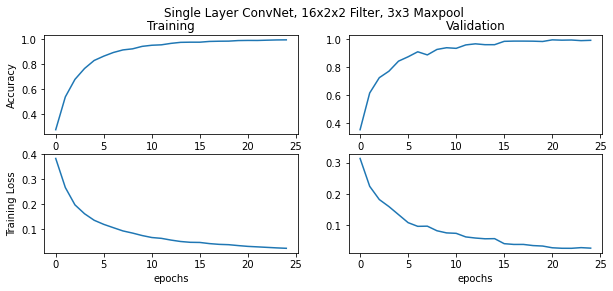

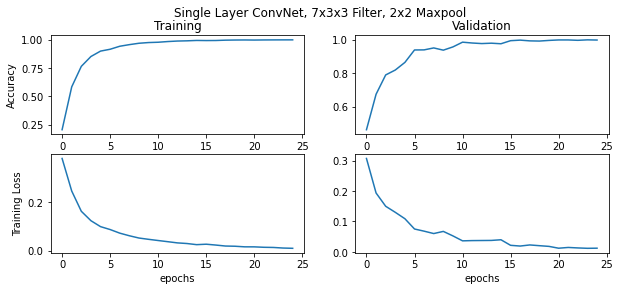

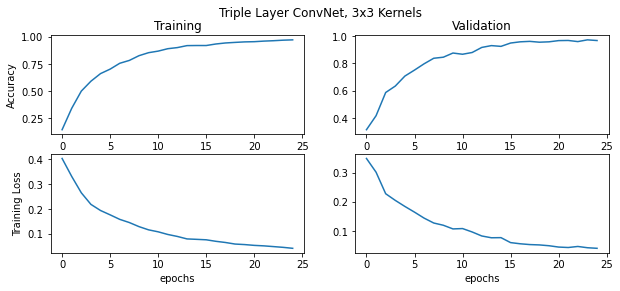

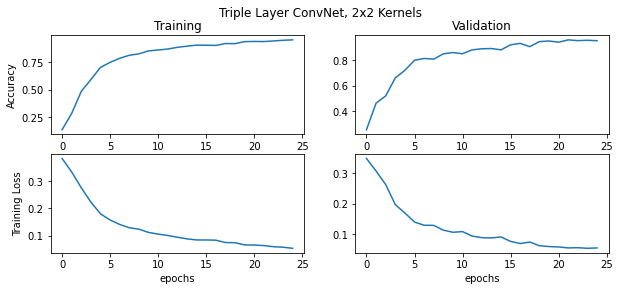

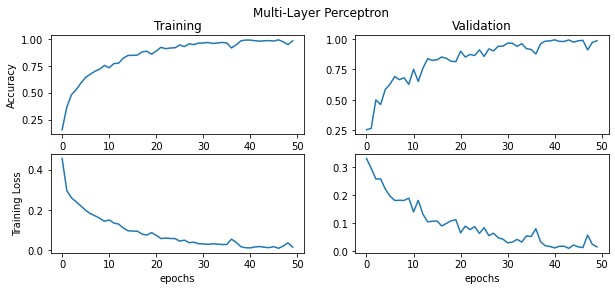

In [7]:
cnn_simple_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_simple_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_advanced_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_advanced_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

cnn_simple_1_histories = []
cnn_simple_2_histories = []
cnn_advanced_1_histories = []
cnn_advanced_2_histories = []
mlp_histories = []
for train_index, test_index in kfold.split(X, y):
    print('Fold Started')
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_train_ohe = keras.utils.to_categorical(y_train, labels)
    y_test_ohe = keras.utils.to_categorical(y_test, labels)

    history = mlp.fit(
        X_train,
        y_train_ohe,
        batch_size=256,
        epochs=10,
        shuffle=True,
        verbose=0,
        validation_data=(X_test, y_test_ohe)
    )
    mlp_histories.append(history)

    history = cnn_simple_1.fit(
        X_train,
        y_train_ohe,
        batch_size=256,
        epochs=5,
        shuffle=True,
        verbose=0,
        validation_data=(X_test, y_test_ohe)
    )
    cnn_simple_1_histories.append(history)

    history = cnn_simple_2.fit(
        X_train,
        y_train_ohe,
        batch_size=256,
        epochs=5,
        shuffle=True,
        verbose=0,
        validation_data=(X_test, y_test_ohe)
    )
    cnn_simple_2_histories.append(history)

    history = cnn_advanced_1.fit(
        X_train,
        y_train_ohe,
        batch_size=256,
        epochs=5,
        shuffle=True,
        verbose=0,
        validation_data=(X_test, y_test_ohe)
    )
    cnn_advanced_1_histories.append(history)

    history = cnn_advanced_2.fit(
        X_train,
        y_train_ohe,
        batch_size=256,
        epochs=5,
        shuffle=True,
        verbose=0,
        validation_data=(X_test, y_test_ohe)
    )
    cnn_advanced_2_histories.append(history)

_, single1_acc, _, single1_error = plot_histories(cnn_simple_1_histories, "Single Layer ConvNet, 16x2x2 Filter, 3x3 Maxpool")
_, single2_acc, _, single2_error = plot_histories(cnn_simple_2_histories, "Single Layer ConvNet, 7x3x3 Filter, 2x2 Maxpool")
_, triple1_acc, _, triple1_error = plot_histories(cnn_advanced_1_histories, "Triple Layer ConvNet, 3x3 Kernels")
_, triple2_acc, _, triple2_error = plot_histories(cnn_advanced_2_histories, "Triple Layer ConvNet, 2x2 Kernels")
_, mlp_acc, _, mlp_error = plot_histories(mlp_histories, "Multi-Layer Perceptron")

### Model Comparison

In [13]:
from math import sqrt

# Approximate variance in error using normal distribution
def different(e1, n1, e2, n2, z = 1.645):
    mean = abs(e2 - e1)
    variance = e1 * (1 - e1) / n1 + e2 * (1 - e2) / n2
    lower_bound = mean - z * sqrt(variance)
    upper_bound = mean + z * sqrt(variance)
    if lower_bound < 0 and upper_bound > 0:
        return False
    else:
        return True

# Number of samples is divided by number of folds to calulcate number of test instances
n = len(y) // 5

print("Single Layer Convnet 1 validation accuracy:", single1_acc)
print("Single Layer Convnet 2 validation accuracy:", single2_acc)
print("Triple Layer Convnet 1 validation accuracy:", triple1_acc)
print("Triple Layer Convnet 2 validation accuracy:", triple2_acc)
print("Multi-Layer Perceptron validation accuracy:", mlp_acc)
print()
print("Single Layer ConvNet 1 and 2", "are" if different(single1_error, n, single2_error, n) else "are not", "significantly different with 90% confidence.")
print("Triple Layer ConvNet 1 and 2", "are" if different(triple1_error, n, triple2_error, n) else "are not", "significantly different with 90% confidence.")
print()
print("Single Layer ConvNet 2 and Triple Layer ConvNet 1", "are" if different(single1_error, n, triple2_error, n) else "are not", "significantly different with 90% confidence.")
print()
print("Single Layer ConvNet 2 and Multi-Layer Perceptron", "are" if different(single1_error, n, mlp_error, n) else "are not", "significantly different with 90% confidence.")

Single Layer Convnet 1 validation accuracy: 0.9900000095367432
Single Layer Convnet 2 validation accuracy: 0.9988889098167419
Triple Layer Convnet 1 validation accuracy: 0.9683333039283752
Triple Layer Convnet 2 validation accuracy: 0.9522222280502319
Multi-Layer Perceptron validation accuracy: 0.9861111044883728

Single Layer ConvNet 1 and 2 are significantly different with 90% confidence.
Triple Layer ConvNet 1 and 2 are significantly different with 90% confidence.

Single Layer ConvNet 2 and Triple Layer ConvNet 1 are significantly different with 90% confidence.

Single Layer ConvNet 2 and Multi-Layer Perceptron are significantly different with 90% confidence.


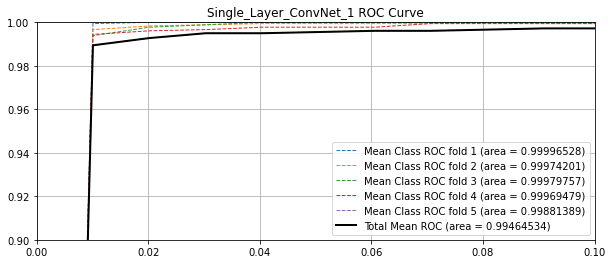

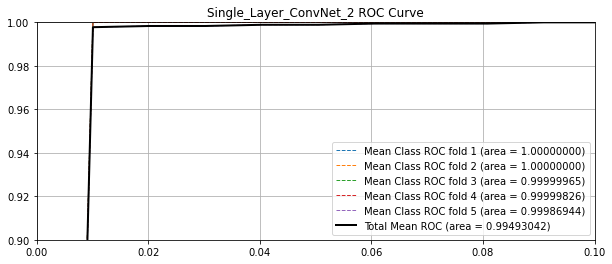

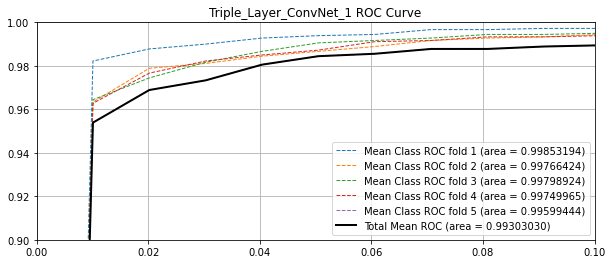

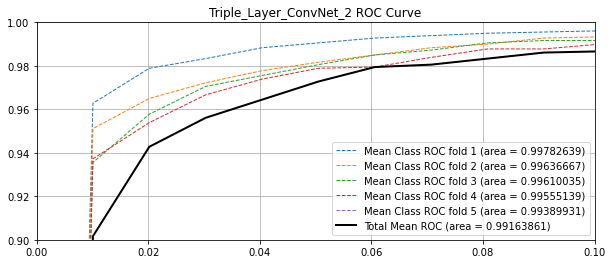

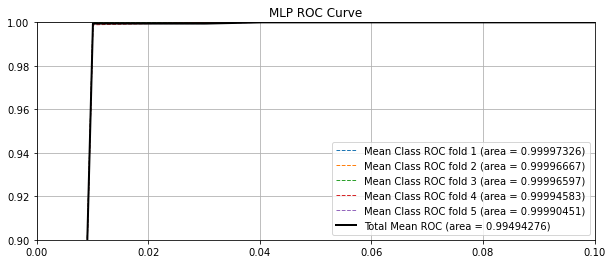

In [9]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

def roc(model, zoom=False):
    plt.figure(figsize=(10,4))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    for f, (train_index, test_index) in enumerate(kfold.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        probas = model.predict(X_test)

        perclass_mean_tpr = 0.0
        roc_auc = 0
        for i in range(labels):
            fpr, tpr, thresholds = roc_curve(y_test, probas[:, i], pos_label=i)
            perclass_mean_tpr += np.interp(mean_fpr, fpr, tpr)
            perclass_mean_tpr[0] = 0.0
            roc_auc += auc(fpr, tpr)
        perclass_mean_tpr /= labels
        roc_auc /= labels
        mean_tpr += perclass_mean_tpr
        plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label=f'Mean Class ROC fold {f+1} (area = {roc_auc:0.8f})')
    mean_tpr /= 5
    mean_auc = auc(mean_fpr, mean_tpr)
    if zoom:
        plt.xlim(0, 0.1)
        plt.ylim(0.9, 1)
    else:
        plt.xlim(0,1)
        plt.ylim(0,1)
    plt.title(f'{model.name} ROC Curve')
    plt.plot(mean_fpr,perclass_mean_tpr,'k-',lw=2,label=f'Total Mean ROC (area = {mean_auc:0.8f})')
    plt.legend(loc='lower right')
    plt.grid()

roc(cnn_simple_1, zoom=True)
roc(cnn_simple_2, zoom=True)
roc(cnn_advanced_1, zoom=True)
roc(cnn_advanced_2, zoom=True)
roc(mlp, zoom=True)

Given the results of statistical analysis and plotting of ROC curves, the second CNN with one layer of convolution performs best. The additional layers of convolution do not appear to significantly improve classification performance, but have a penalty on speed of training and convergence. In fact, because the Multi-Layer Perceptron progresses through epochs more quickly, increasing the number of its training epochs may allow the MLP to match or surpass the accuracy of the Single-Layer CNN without surpassing real-world execution time. However, that has not been explored in this analysis.

## Transfer Learning

Two new networks with two layers of convolution will be based on the first single layer convnet built earlier. The first network will be built completely from scratch with an idential first convolutional layer. The second network will be loaded from the earlier model with pretrained weights, then modified to add additional convolution.

In [10]:
from tensorflow.keras.models import load_model
from keras.models import Model

# Save weights of neural net
cnn_simple_1.save('cnn_simple_1')

# Create new network similar to the first single-layer convnet, but with a second layer of convolution before classification
cnn_untrained = Sequential(name="Double_Layer_ConvNet")
cnn_untrained.add(Conv2D(
    filters=64,
    kernel_size=(3,3),
    padding='same',
    data_format='channels_last',
    input_shape=(size, size, channels),
))
cnn_untrained.add(MaxPooling2D(
    pool_size=(3,3),
    data_format='channels_last'
))
cnn_untrained.add(Conv2D(
    filters=128,
    kernel_size=(3,3),
    padding='same',
    data_format='channels_last',
    input_shape=(size, size, channels),
))
cnn_untrained.add(MaxPooling2D(
    pool_size=(3,3),
    data_format='channels_last'
))
cnn_untrained.add(Activation('relu'))
cnn_untrained.add(Flatten())
cnn_untrained.add(Dense(
    labels,
    activation='sigmoid',
    kernel_initializer='glorot_uniform'
))
cnn_untrained.summary()

# Create a copy of the same network, but with the first layer of convolution pre-trained
loaded_model = load_model('cnn_simple_1')
loaded_model._layers.pop()
loaded_model._layers.pop()
loaded_model._layers.pop()
x = Conv2D(
    filters=128,
    kernel_size=(3,3),
    padding='same',
    data_format='channels_last',
    input_shape=(size, size, channels)
)(loaded_model.layers[-1].output)
x = MaxPooling2D(
    pool_size=(3,3),
    data_format='channels_last'
)(x)
x = Activation('relu')(x)
x = Flatten()(x)
x = Dense(labels, activation='sigmoid', kernel_initializer='glorot_uniform')(x)
cnn_pretrained = Model(name="Double_Layer_ConvNet_Pretrained", inputs=loaded_model.input, outputs=[x])
cnn_pretrained.summary()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: cnn_simple_1\assets
Model: "Double_Layer_ConvNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 89, 89, 64)        1792      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 9, 9, 128)         0         
_________________________________________________________________
activation_2 (Activat

Fold Started
Epoch 1/5
29/29 - 29s - loss: 0.3715 - accuracy: 0.2124 - val_loss: 0.3176 - val_accuracy: 0.3311
Epoch 2/5
29/29 - 28s - loss: 0.2728 - accuracy: 0.4651 - val_loss: 0.2287 - val_accuracy: 0.5778
Epoch 3/5
29/29 - 28s - loss: 0.2039 - accuracy: 0.6433 - val_loss: 0.1779 - val_accuracy: 0.7111
Epoch 4/5
29/29 - 29s - loss: 0.1625 - accuracy: 0.7437 - val_loss: 0.1540 - val_accuracy: 0.7544
Epoch 5/5
29/29 - 29s - loss: 0.1339 - accuracy: 0.8118 - val_loss: 0.1248 - val_accuracy: 0.8194
Fold Started
Epoch 1/5
29/29 - 29s - loss: 0.1186 - accuracy: 0.8411 - val_loss: 0.1114 - val_accuracy: 0.8628
Epoch 2/5
29/29 - 28s - loss: 0.1004 - accuracy: 0.8825 - val_loss: 0.0981 - val_accuracy: 0.8817
Epoch 3/5
29/29 - 28s - loss: 0.0908 - accuracy: 0.8908 - val_loss: 0.0868 - val_accuracy: 0.9072
Epoch 4/5
29/29 - 28s - loss: 0.0783 - accuracy: 0.9201 - val_loss: 0.0790 - val_accuracy: 0.9200
Epoch 5/5
29/29 - 28s - loss: 0.0701 - accuracy: 0.9339 - val_loss: 0.0752 - val_accuracy: 0

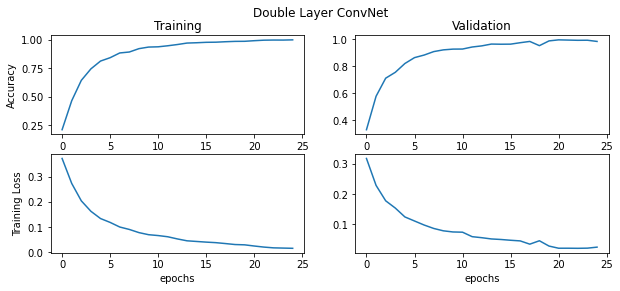

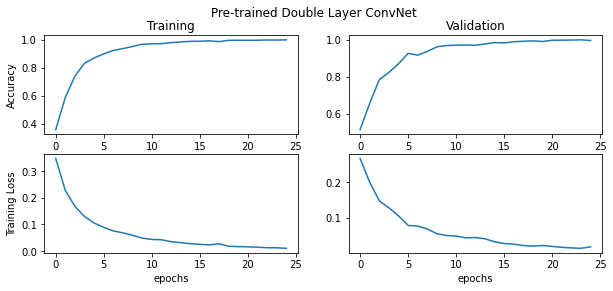

In [11]:
cnn_untrained.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_pretrained.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

cnn_untrained_histories = []
cnn_pretrained_histories = []
for train_index, test_index in kfold.split(X, y):
    print('Fold Started')
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_train_ohe = keras.utils.to_categorical(y_train, labels)
    y_test_ohe = keras.utils.to_categorical(y_test, labels)

    history = cnn_untrained.fit(
        X_train,
        y_train_ohe,
        batch_size=256,
        epochs=5,
        shuffle=True,
        verbose=0,
        validation_data=(X_test, y_test_ohe)
    )
    cnn_untrained_histories.append(history)

    history = cnn_pretrained.fit(
        X_train,
        y_train_ohe,
        batch_size=256,
        epochs=5,
        shuffle=True,
        verbose=0,
        validation_data=(X_test, y_test_ohe)
    )
    cnn_pretrained_histories.append(history)

_, untrained_acc, _, untrained_error = plot_histories(cnn_untrained_histories, "Double Layer ConvNet")
_, pretrained_acc, _, pretrained_error = plot_histories(cnn_pretrained_histories, "Pre-trained Double Layer ConvNet")

The network with a pre-trained first layer starts with better accuracy and converges more quickly.